In [9]:
import numpy as np
import numpy.linalg as LA
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import sys 
sys.path.append("../")
from libs.create import create_norm_data, create_out_cov
from libs.functions import sigmoid, g_lo, g_up

n = 1000
m = 3*n
eps = 0.1
data_dim = 2
mu = 0
mu_out = 6
par_mu = np.full(data_dim, mu)
# par_sd = np.identity(data_dim)
out_mu = np.full(data_dim, mu_out)

par_reg1=0.005
exper_iter = 3
optim_iter = 50
L = 5
learn_par = 0.005
dicay_par = 0.3

In [11]:
# 分散を固定しない
par_cov = np.eye(data_dim)
out_cov = np.eye(data_dim)
true_alpha = [par_mu, par_cov]
res_mean = [0 for i in range(exper_iter)]
res_cov = [0 for i in range(exper_iter)]
res_par = [0 for i in range(exper_iter)]
for i in (range(exper_iter)):
    data = create_norm_data(n, eps, par_mu, par_cov, out_mu, out_cov)
    mean_hist = []
    cov_hist = []
    par_hist = []
    # 平均は次元ごとにロバスト、分散はロバストでない
    alpha = [np.median(data, axis=0), np.cov(data, rowvar = False)]
    z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)

    def discriminator(x, beta):
        size, data_dim = x.shape[0], x.shape[-1]
        stack = [x, x**2]
        value = np.dot(np.stack(stack, axis=1).reshape(size, len(stack)*data_dim),beta)
        return value

    par = np.random.normal(loc = 0, scale = 0.1, size = 2*data_dim)
    bias = np.array(np.mean( discriminator(z, par[0:2*data_dim]) ))[np.newaxis]
    par = np.concatenate([par, bias], axis = 0)
    for j in tqdm(range(1, optim_iter+1)):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1] , size = m)
        def major_func(par, past_par):
            new_beta = par[0:2*data_dim]; new_b = par[2*data_dim]; beta = past_par[0:2*data_dim]; b = past_par[2*data_dim]
            A = np.mean(g_lo(discriminator(z, new_beta) - new_b, discriminator(z, beta) - b))
            B = np.mean(g_up(discriminator(data, new_beta) - new_b, discriminator(data, beta) - b))
            reg = LA.norm(new_beta, ord=2)*par_reg1
            return -(A-B - reg)

        l = 0
        while(l<L):
            op = minimize(major_func, x0 = par, args = par)
            par = op.x
            l+=1
        
        alpha_m = alpha[0]; alpha_v = alpha[1]
        v_inv = np.linalg.inv(alpha_v)
        mgrad = (v_inv*(z-alpha_m)[:, np.newaxis, :]).sum(axis=2)
        sigma_grad = (alpha_v - (z- alpha_m)[:,:,np.newaxis] * (z-alpha_m)[:, np.newaxis, :])/2
        sig_ = sigmoid(discriminator(z, par[:2*data_dim]) - par[2*data_dim])[:,np.newaxis]
        tmp_alpha_m = alpha[0] - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        tmp_alpha_v = v_inv - learn_par/j**dicay_par * np.mean(sigma_grad*sig_[:,:,np.newaxis], axis = 0)
        alpha[0], alpha[1] = tmp_alpha_m, (LA.inv(tmp_alpha_v))

        mean_hist.append(alpha[0])
        cov_hist.append(alpha[1])
        par_hist.append(par)
    res_mean[i] = mean_hist
    res_cov[i] = cov_hist
    res_par[i] = par_hist


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


In [14]:
def plot():
    mean = np.array(res_mu)
    cov = np.array(res_cov)
    par = np.array(res_par)
    mean_vec = np.full(data_dim, mu)
    cov_mat = np.eye(data_dim)
    
    mean_end = []; cov_end = []
    for i in range(exper_iter):
        loss_mean = LA.norm(mean[i] - mean_vec, ord = 2, axis = 1)
        plt.plot(loss_mean)
        mean_end.append(loss_mean[-1])
    print("mean ave : %.5f" %np.mean(mean_end))
    print("mean std : %.5f" %np.std(mean_end))


    plt.subplots()
    for i in range(exper_iter):
        loss_cov = LA.norm(cov[i] - cov_mat, ord = 2, axis = (1,2))
        plt.plot(loss_cov)
        cov_end.append(loss_cov[-1])
    print("cov  ave : %.5f" %np.mean(cov_end))
    print("cov  std : %.5f" %np.std(cov_end))

    for i in range(exper_iter):
        plt.subplots()
        for j in range(par.shape[2]):
            plt.plot(par[i,:,j], label=str(j))
            plt.legend()
        


def plot_sig():
    mean = np.array(res_mean)
    cov = np.array(res_cov)
    par = np.array(res_par)
    for j in range(exper_iter):
        l = []
        for i in range(optim_iter):
            z = np.random.multivariate_normal(mean[j,i], cov[j,i], size = 3000)
            par_ = par[j,i]
            sig_ = (sigmoid(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),par_[0:2*data_dim ])- par_[2*data_dim])[:,np.newaxis]).mean()
            l.append(sig_)
        plt.plot(l)


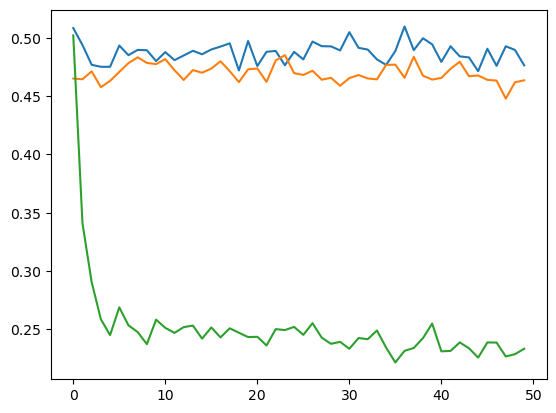

In [15]:
plot_sig()

mean ave : 0.24148
mean std : 0.01659
cov  ave : 3.83971
cov  std : 0.42218


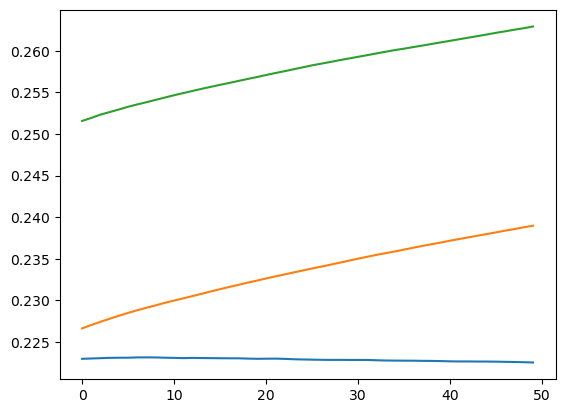

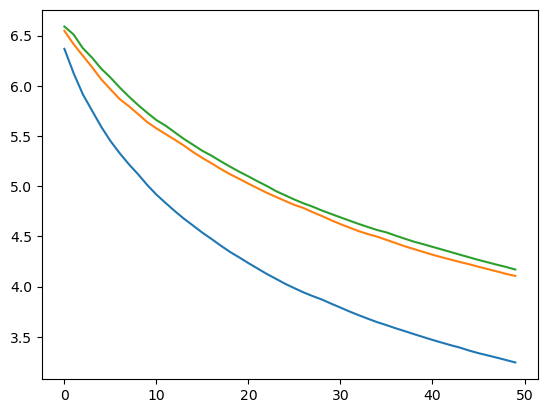

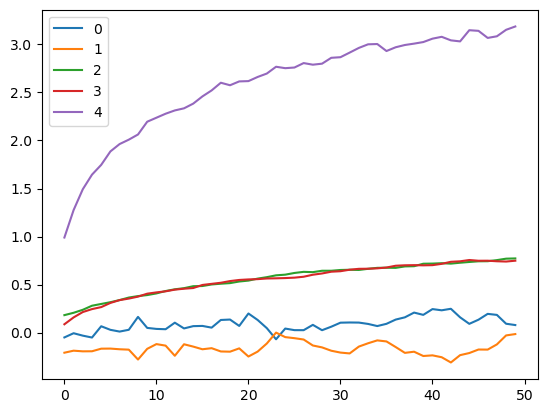

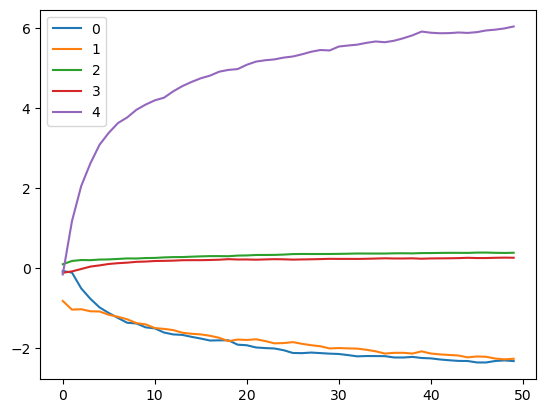

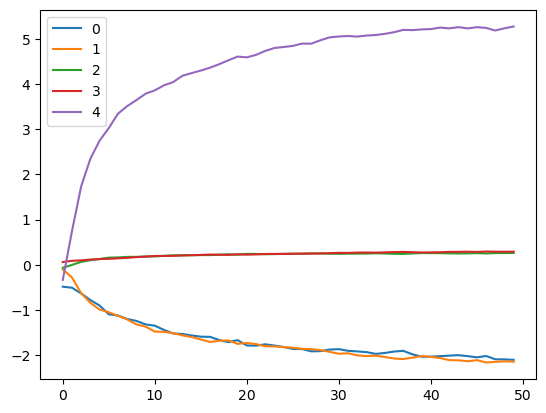

In [71]:
plot()